In [1]:
# Allow imports from parent directory - robust incase run twice 
import os, sys
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    sys.path.append(os.path.abspath(".")) 

# Imports for this notebook 
from analysis import apogee_filter
from analysis import galah_filter

from astropy.coordinates import SkyCoord, Galactocentric, CylindricalRepresentation, CylindricalDifferential, CartesianDifferential
import astropy.units as u
from astropy.units import Quantity
from astropy.table import Table, join

import numpy as np
from scipy.stats import norm
from tabulate import tabulate

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.stats import norm
from matplotlib.patches import Patch

## Note on Data Required In This Notebook
- The full datasets required in this notebook will need to be downloaded from [Research Project - Google Drive Data](https://drive.google.com/drive/u/1/folders/1kldDRZKpXAH3Szk839DRJjNsZq1ekQ2D)
- Please see [README](README.md) for full details.
- Beyond this the resultant datasets are stored locally in the respostory [here](data/filtered/)

## **Importing/ Filtering Apogee Data**

| **Dataset**         | **Variable**                     | **Description** |
|---------------------|---------------------------------|----------------|
| **Apogee Data**      | `apogee_data_path`              | Contains stellar data from Apogee DR3, including elemental abundances, and additional data |


###  apogee_filter
- Preforms a series of data quality cuts outlined by docstring below
- Also preforms SQL queries to retain Gaia data, including photogeometric distance estimates from *Bailer-Jones 2021* (VAC).


**Filtering Criteria**

This section outlines the criteria applied to filter the stellar data, ensuring a high-quality sample for subsequent analysis.

**1. Data Quality Cuts**

* `extratarg == 0`: Selects only Main Red Stars (MRS).
* `logg < 3.0`: Restricts the sample to giant stars.

**2. Element Abundance Filters**

* **[Fe/H]:** Requires `fe_h_flag == 0` and `fe_h_err < 0.1` for reliable iron abundance measurements.
* **[Al/Fe]:** Requires `al_fe_flag == 0` and `al_fe_err < 0.1` for accurate aluminum abundance measurements.
* **[Ce/Fe]:** Requires `ce_fe_flag == 0` and `ce_fe_err < 0.15` for precise cerium abundance measurements.

**3. Derived Element Ratio Filters**

* **[Mg/Mn]:** Computed as `mg_fe - mn_fe` if missing. Requires:
    * `mg_mn_flag == 0` (or `mg_fe_flag == 0` & `mn_fe_flag == 0` if `mg_mn_flag` is not available).
    * `mg_mn_err < 0.1` for a reliable measurement.
* **[alpha/Fe]:** Constructed from individual alpha elements if missing. Requires:
    * From the APOGEE documentation we thus consider the flags for `O, Mg, Si, S, Ca, and Ti`
    * `alpha_fe_flag == 0` and `alpha_fe_err < 0.1`.

**4. Orbital and Kinematic Cuts**

* `Eccentricity (ecc_50) > 0.85`: Selects stars on highly radial orbits.
* `Energy (E_50) < 0`: Removes unbound or high-energy stars.

**5. Additional Filters (If SQL=True)**

* Queries **Gaia DR3** for distance information (`r_med_photogeo`, `r_lo_photogeo`, `r_hi_photogeo`).
* **Distance Uncertainty Cut**: Rejects stars with:
    * `(r_hi_photogeo - r_med_photogeo) < 1500` pc (upper bound uncertainty).
    * `(r_med_photogeo - r_lo_photogeo) < 1500` pc (lower bound uncertainty).

**6. Ensuring Data Consistency**

* Checks for the presence of required keys before applying filters.
* Drops stars with missing values in `ecc_50` or `E_50`.
* Orders the dataset to maintain consistency across operations.
* Ensures the Gaia ID (`GAIAEDR3_SOURCE_ID` or `dr3_source_id`) is present when `SQL=True`.

In [2]:
# Input path
apogee_data_path = 'data/raw/Apogee_GM/Apogee_DS_GM.csv'

# Output path
apogee_data_filtered_path = 'data/filtered/Apogee/Apogee_data_filtered_1612.csv'

In [3]:
?apogee_filter

Signature: apogee_filter(star_data_in, SQL=False, save_path=None)
Docstring:
Applies quality cuts to APOGEE stellar data to produce a refined 
sample of chemically selected stars with extreme kinematics.

This function filters stars based on data quality, chemical abundances, 
and orbital properties to isolate **metal-poor stars with extreme orbits**.

If `SQL=True`, Gaia DR3 distances are queried using the **astroquery** package, 
and an additional filtering step removes stars with large distance errors.

Parameters
----------
star_data_in : str, Table, np.recarray, or pd.DataFrame
    APOGEE stellar data, provided as a file path (CSV, FITS, TXT) or an 
    Astropy Table, NumPy recarray, or Pandas DataFrame.

SQL : bool, optional
    If `True`, queries Gaia DR3 for distances using `astroquery.gaia` 
    and applies additional filtering based on distance uncertainties.
    Defaults to `False`.

save_path : str, optional
    If provided, saves the filtered dataset as a FITS file at the 

In [4]:
apogee_processed_data = apogee_filter(apogee_data_path, SQL=True, save_path = apogee_data_filtered_path)

INFO:root:Initial number of stars: 1706
INFO:root:Querying Gaia for distances...
Processing Queries: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]
INFO:root:Final number of stars: 1612
INFO:root:Fraction retained: 94.49%
INFO:root:Filtered dataset saved to data/filtered/Apogee/Apogee_data_filtered_1612.csv
INFO:root:
=== Filter Diagnostics: Stars Rejected by Each Criterion ===
INFO:root:Main Red Stars (extratarg == 0) →    0 stars removed
INFO:root:logg < 3.0                     →    0 stars removed
INFO:root:[Fe/H] quality                 →    0 stars removed
INFO:root:[Al/Fe] quality                →    0 stars removed
INFO:root:[Ce/Fe] quality                →    0 stars removed
INFO:root:[Mg/Mn] quality                →    0 stars removed
INFO:root:[alpha/Fe] Overall Cut         →   32 stars removed
INFO:root:[alpha/Fe] - [O/Fe]            →    2 stars removed
INFO:root:[alpha/Fe] - [Mg/Fe]           →    0 stars removed
INFO:root:[alpha/Fe] - [Si/Fe]           →    1 stars removed

## **Investigating the removed data from that used in Myeong et al. 2022**
- Here we investigate the stars that have been removed in more detail.
- It is important to consider the difference created in the dataset despite only being 5.51% smaller

Parameter      Mean (Kept)           Std (Kept)       Mean (Rejected)       Std (Rejected)  
--------- --------------------- ------------------- -------------------- -------------------
     fe_h   -0.9740427065756824  0.3660433080244963  -1.2213090425531914  0.3945209120851359
  alpha_m   0.21795620843672453 0.07420455563379455  0.21264262765957453 0.08104783729864044
     E_50    -160813.1583602587   20379.19771028444  -155396.93328186648  20721.536371713817
    ce_fe   -0.1409265446650124  0.2501541347682489 -0.09595915957446806 0.33493066195656973
    al_fe -0.046384794665012406  0.2401792933202058 -0.12177871276595746 0.28447668683707716
    mg_mn   0.47646336848635235 0.14764347245640275    0.460865414893617   0.159003950180652


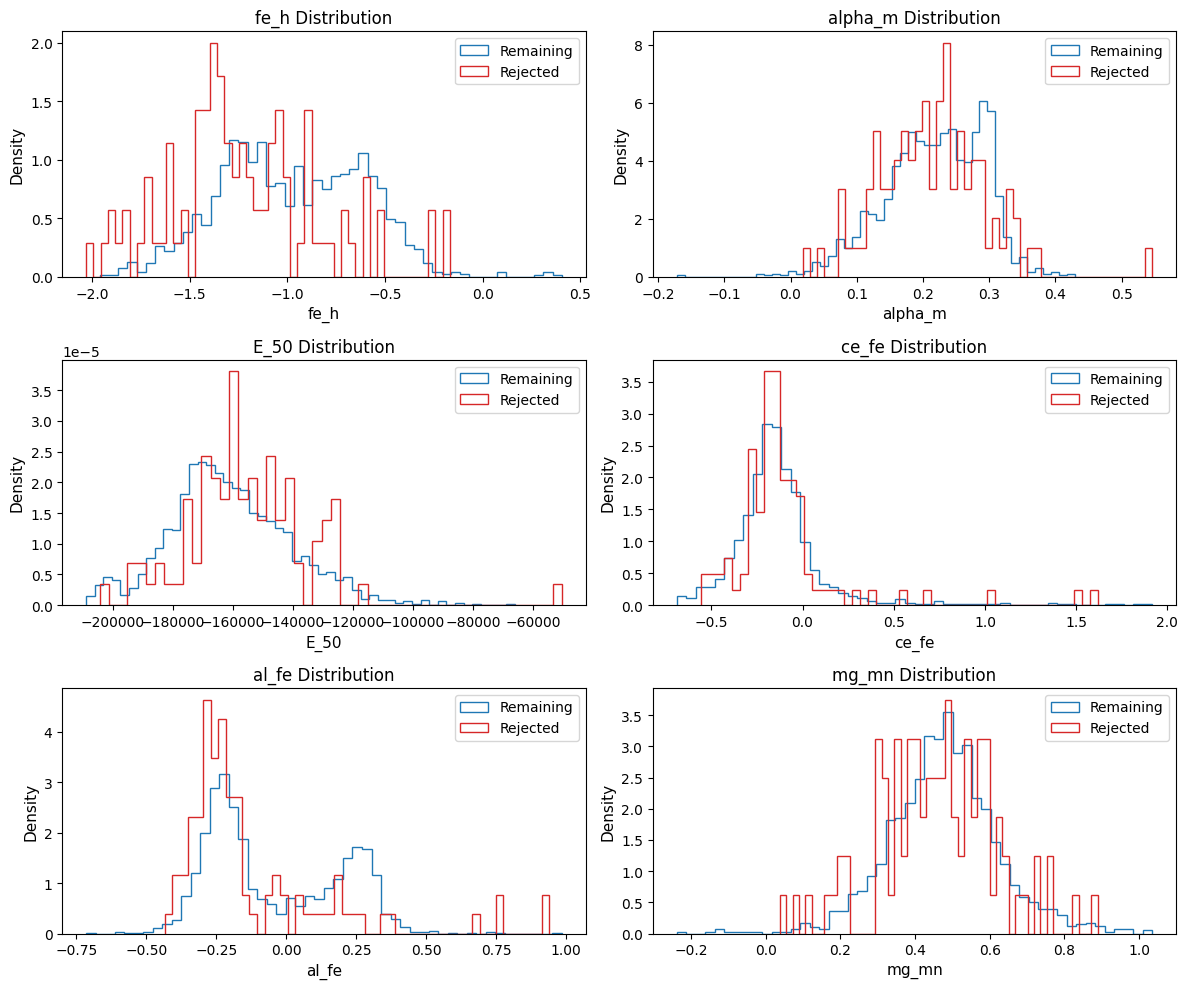

In [23]:
apogee_origial_data = Table.read(apogee_data_path, format='csv')
# Identify rejected entries
rejected_mask = ~np.isin(apogee_origial_data['dr3_source_id'], apogee_processed_data['dr3_source_id'])
apogee_rejected_stars = apogee_origial_data[rejected_mask]

# Now compare the two tables means and stds to see if cuts remove a corrolated distribution of stars
# Dimensions of instrest
apogee_data_keys = ['fe_h', 'alpha_m', 'E_50', 'ce_fe', 'al_fe', 'mg_mn']

# Create a table of means and stds
# Compute means and stds for each dataset
def get_stats(table, keys):
    stats = {'Parameter': [], 'Mean': [], 'Std': []}
    for key in keys:
        values = table[key]
        values = values[np.isfinite(values)]  # remove NaNs
        stats['Parameter'].append(key)
        stats['Mean'].append(np.mean(values))
        stats['Std'].append(np.std(values))
    return Table(stats)

# Calculate stats for remaining and rejected stars
stats_processed = get_stats(apogee_processed_data, apogee_data_keys)
stats_rejected = get_stats(apogee_rejected_stars, apogee_data_keys)

# Display table
comparison_table = stats_processed.copy()
comparison_table.rename_column('Mean', 'Mean (Kept)')
comparison_table.rename_column('Std', 'Std (Kept)')
comparison_table['Mean (Rejected)'] = stats_rejected['Mean']
comparison_table['Std (Rejected)'] = stats_rejected['Std']
comparison_table.pprint_all()

# Plot normalised hostogram of each parameter in a 3 x 2 grid
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

# Loop through all the keys and create a histogram of each
for i, key in enumerate(apogee_data_keys):
    # Extract relavent data dimension
    kept_vals = apogee_processed_data[key]
    rejected_vals = apogee_rejected_stars[key]

    # Plot normalized histograms
    axs[i].hist(kept_vals, bins=50, density=True, alpha=1, label='Remaining', color='tab:blue', histtype='step')
    axs[i].hist(rejected_vals, bins=50, density=True, alpha=1, label='Rejected', color='tab:red', histtype='step')

    axs[i].set_title(f"{key} Distribution", fontsize=12)
    axs[i].set_xlabel(key, fontsize=11)
    axs[i].set_ylabel("Density", fontsize=11)
    axs[i].legend()
    axs[i].tick_params(labelsize=10)

plt.tight_layout()
plt.show()



## **Importing/ Filtering Galah Data**

| **Dataset**         | **Variable**                     | **Description** |
|---------------------|---------------------------------|----------------|
| **Galah Data**      | `galah_data_path`              | Contains stellar data from Galah DR3, including elemental abundances. |
| **Dynamical Data**  | `galah_data_dynamics_path`     | Contains dynamical parameters from *Bovy 2015*, such as Energy, Eccentricity, Apocentre, and Action Variables (VAC). |
| **Gaia Data**       | `galah_data_gaia_path`         | Contains Gaia data, including photogeometric distance estimates from *Bailer-Jones 2021* (VAC). |


###  galah_filter


**Filtering Criteria**

This section details the criteria used to filter the stellar data, ensuring a robust and reliable sample for subsequent analysis.

**1. Data Quality Cuts**

* `flag_sp == 0`: Includes only stars with reliable stellar parameters.
* `snr_c3_iraf > 30`: Ensures a good signal-to-noise ratio (SNR) in the spectra.
* `logg < 3.0`: Selects only giant stars.

**2. Element Abundance Filters**

* **[Fe/H]:** Includes stars with `flag_fe_h == 0` and a measurement error `e_fe_h < 0.2`.
* **[alpha/Fe]:** Includes stars with `flag_alpha_fe == 0` and a measurement error `e_alpha_fe < 0.2`.
* **[Na/Fe]:** Excludes stars with unreliable sodium measurements (`flag_Na_fe == 0` and `e_Na_fe < 0.2`).
* **[Al/Fe]:** Excludes stars with unreliable aluminum measurements (`flag_Al_fe == 0` and `e_Al_fe < 0.2`).
* **[Mn/Fe]:** Excludes stars with unreliable manganese measurements (`flag_Mn_fe == 0` and `e_Mn_fe < 0.2`).
* **[Y/Fe]:** Excludes stars with unreliable yttrium measurements (`flag_Y_fe == 0` and `e_Y_fe < 0.2`).
* **[Ba/Fe]:** Excludes stars with unreliable barium measurements (`flag_Ba_fe == 0` and `e_Ba_fe < 0.2`).
* **[Eu/Fe]:** Excludes stars with unreliable europium measurements (`flag_Eu_fe == 0` and `e_Eu_fe < 0.2`).

**3. Derived Element Ratio Filters**

* **[Mg/Cu]:** Excludes stars with unreliable magnesium-to-copper ratios (`flag_Mg_Cu == 0`, `e_Mg_Cu < 0.2`).
* **[Mg/Mn]:** Excludes stars with unreliable magnesium-to-manganese ratios (`flag_Mg_Mn == 0`, `e_Mg_Mn < 0.2`).
* **[Ba/Eu]:** Excludes stars with unreliable barium-to-europium ratios (`flag_Ba_Eu == 0`, `e_Ba_Eu < 0.2`).

**4. Orbital and Kinematic Cuts**

* `Eccentricity > 0.85`: Selects stars on highly radial orbits.
* `Energy < 0`: Removes stars with unbound or positive energy.
* `R_ap > 5`: Requires an apocenter (farthest orbital point) larger than 5 kpc, focusing on outer halo structures.

**5. Distance Uncertainty Cut (Gaia)**

* `(r_hi_photogeo - r_med_photogeo) < 1500 pc`: Rejects stars with a large upper uncertainty in their photogeometric distance.
* `(r_med_photogeo - r_lo_photogeo) < 1500 pc`: Rejects stars with a large lower uncertainty in their photogeometric distance.

**6. Ensuring Data Consistency**

* The GALAH, Gaia, and dynamics datasets are matched using the `sobject_id`.
* All datasets are ordered to maintain consistency across different analyses.
* Duplicate entries within the combined dataset are removed.

In [24]:
# Input paths
galah_data_path = 'data/raw/Galah_DR3/GALAH_DR3_main_allstar_v3.fits'
galah_data_dynamics_path = 'data/raw/Galah_DR3/GALAH_DR3_VAC_dynamics_v2.fits'
galah_data_gaia_path = 'data/raw/Galah_DR3/GALAH_DR3_VAC_GaiaEDR3_v2.fits'

# Output paths
galah_data_filtered_path = 'data/filtered/Galah/Galah_data_filtered_1061.fits'

In [25]:
?galah_filter

Signature: galah_filter(star_data_in, dynamics_data_in, gaia_data_in, save_path=None)
Docstring:
Applies quality cuts to GALAH, Gaia, and dynamics datasets to produce 
a refined sample of metal-poor, high-eccentricity stars. 

This function filters stars based on data quality, chemical abundances, 
orbital properties, and distance uncertainties.

Parameters
----------
star_data_in : str, Table, np.recarray, or pd.DataFrame
    GALAH stellar data, provided as a file path (CSV, FITS, TXT) or an 
    Astropy Table, NumPy recarray, or Pandas DataFrame.

dynamics_data_in : str, Table, np.recarray, or pd.DataFrame
    Dynamics dataset containing orbital properties (e.g., energy, 
    eccentricity, actions).

gaia_data_in : str, Table, np.recarray, or pd.DataFrame
    Gaia dataset providing distances and photogeometric uncertainties. 

save_path : str, optional
    If provided, saves the filtered dataset as a FITS file at the specified path.

Returns
-------
Table
    An Astropy Table contain

In [26]:
galah_processed_data = galah_filter(galah_data_path, galah_data_dynamics_path, galah_data_gaia_path, save_path=galah_data_filtered_path)

INFO:root:Initial number of stars: 588571
INFO:root:Final number of stars: 1061
INFO:root:Fraction retained: 0.18%
INFO:root:Filtered dataset saved to data/filtered/Galah/Galah_data_filtered_1061.fits


## Understanding the Distribution of this data (non-chemical space)
- Here I plot some of the distributions of the resultant dataset 
- The chemical dimensions are not focoused on as they are visible throughout this work in the histograms of the Gaussian Mixture Model Plots etc

In [27]:
# Galiocentric Frame
gc_frame = Galactocentric(galcen_distance=8.1 * u.kpc, z_sun=25. * u.pc)

## **Galah Dataset**

In [28]:
# Galah Analysis
galah_distances = Quantity(galah_processed_data['r_med_photogeo'], unit=u.pc)

# Construct SkyCoord with just position
galah_coords = SkyCoord(
    ra=galah_processed_data['ra_dr2'] * u.deg,
    dec=galah_processed_data['dec_dr2'] * u.deg,
    distance=galah_distances,
    frame='icrs'
)

# Get heliocentric distance
galah_r_helio = galah_coords.distance.to(u.kpc)

# Transform to Galactocentric frame 
galcen_coords = galah_coords.transform_to(gc_frame)

# Extract cylindrical components
galah_galcen_cyl = galcen_coords.represent_as(CylindricalRepresentation)
galah_R_gc = galah_galcen_cyl.rho.to(u.kpc)
galah_Z_gc = galcen_coords.z.to(u.kpc)

# Metallicity
galah_metallicity = galah_processed_data['fe_h']

# G band magnitude
galah_gband = galah_processed_data['phot_g_mean_mag']

## **Apogee Dataset**

In [29]:
# Load full original APOGEE catalog
all_apogee = Table.read("data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits")

# The required columns from the APOGEE catalog that will allow the calculation of the Azimuthal velocity
# [ID for matching, RA, DEC, photogeometric distance]
needed_cols = ['APOGEE_ID', 'RA', 'DEC', 'GAIAEDR3_R_MED_PHOTOGEO', 'GAIAEDR3_PHOT_G_MEAN_MAG']
all_apogee = all_apogee[needed_cols]

# Rename columns to enable matched joining (as cluster data has lowercase 'apogee_id')
all_apogee.rename_column('APOGEE_ID', 'apogee_id')

# Join the tables together based on the 'APOGEE_ID' column
matched = join(apogee_processed_data, all_apogee, keys='apogee_id', join_type='inner')
# Avoid duplicate columns by only taking the first occurrence of each column
unique_ids, first_indices = np.unique(matched['apogee_id'], return_index=True)
matched_unique = matched[first_indices]
matched = matched_unique

# Construct SkyCoord with proper motion, photogeometric distance, and APOGEE radial velocity
apogee_coord = SkyCoord(ra=matched['RA'] * u.deg,
                 dec=matched['DEC'] * u.deg,
                 distance=matched['GAIAEDR3_R_MED_PHOTOGEO'] * u.pc,
                 frame='icrs')

# Get heliocentric distance
apogee_r_helio = apogee_coord.distance.to(u.kpc)

# Transform to Galactocentric frame 
galcen_coords = apogee_coord.transform_to(gc_frame)

# Extract cylindrical components
apogee_galcen_cyl = galcen_coords.represent_as(CylindricalRepresentation)
apogee_R_gc = apogee_galcen_cyl.rho.to(u.kpc)
apogee_Z_gc = galcen_coords.z.to(u.kpc)

# Metallicity
apogee_metallicity = apogee_processed_data['fe_h']

# G band magnitude
apogee_gband = matched['GAIAEDR3_PHOT_G_MEAN_MAG']

## Galah and Apogee Comparison

---

### GALAH’s Focus:
* **Primary Goal:** Chemo-dynamical mapping of the Milky Way disc
* **Target Stars:** Nearby main-sequence and turnoff stars (V ≲ 14)
* **Wavelengths:** Optical
* **Observational Focus:**
    * Primarily the solar neighborhood.
    * Focoused on the Galactic southern hemisphere.
    * Less far reaching than the Apogee's data range
* **Advantages:** 
    * Measures over 30 elemental abundances (more than that by Apogee) allow greater seperate by unqiue seperation history
    * Excellent for multi-dimensional abundance analysis.
---

### APOGEE’s Focus:
* **Primary Goal:** Survey all major Galactic components — bulge, disc, and halo — using dust-penetrating IR spectroscopy
* **Target Stars:** Primarily red giant stars
* **Wavelengths:** Near-infrared
* **Observational Focus:**
    * Allow the survey probing all regions and to greater distances
    * Inner Galaxy, Galactic plane, bulge, and halo
    * Both Northern and Southern hemispheres.
* **Advantages:** 
    * Accesses stars in dusty, crowded regions, as well as those in metal-poor populations 
    * Captures the wider chemo-dynamic structure of the Galaxy (with insight to older popultations)

---

### Consequences 

* **APOGEE has a greater population of low-metallicity stars, down to [M/H] $\approx$ -2**
    * APOGEE observe the galaxy in the near-infrared band, allowing it to see deeper into the dust-obscured inner Galaxy.
    * Its selection function includes distant giants and halo stars.
    * Better at studying halo substructure which GALAH may under-represent.
    * GALAH only reaches [M/H] $\approx$ -1.5
    * Ie populations such as GS/E's lower metalicities may be visible in APOGEE but not GALAH

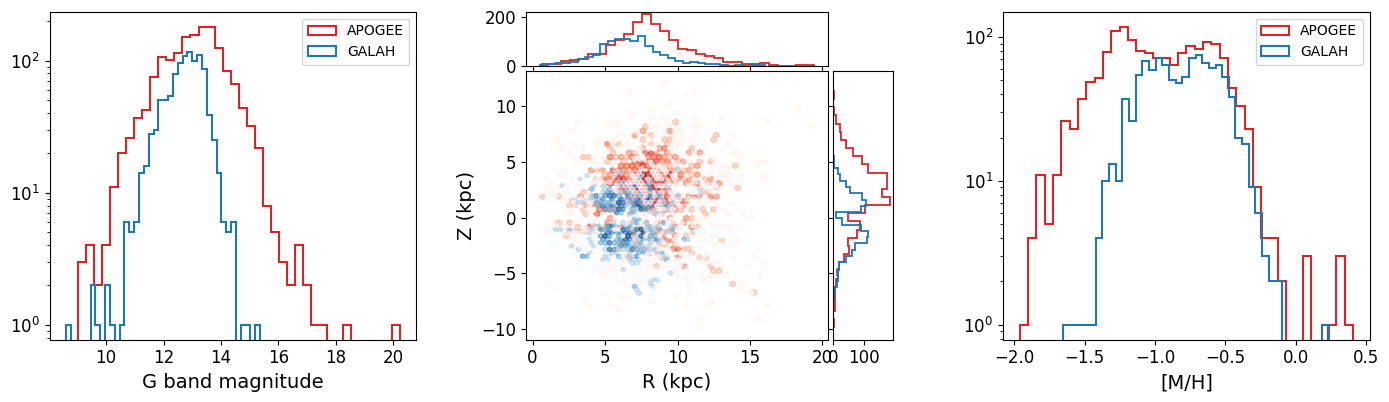

In [30]:
label_fontsize = 14
tick_fontsize = 12
# Set up the plot
fig = plt.figure(figsize=(15, 4))
gs_outer = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.3)

# # Heliocentric Distance Histogram
# ax0 = fig.add_subplot(gs_outer[0])
# # APOGEE
# ax0.hist(apogee_r_helio, bins=30, histtype='step', color='tab:red', linewidth=1.5, log=True, label='APOGEE')
# # GALAH
# ax0.hist(galah_r_helio, bins=30, histtype='step', color='tab:blue', linewidth=1.5, log=True, label='GALAH')
# ax0.set_xlabel("Heliocentric distance (kpc)", fontsize=label_fontsize)
# ax0.set_yscale("log")
# ax0.tick_params(axis='both', labelsize=tick_fontsize)
# ax0.legend(fontsize=10)

# G band magnitude Histogram
ax0 = fig.add_subplot(gs_outer[0])
# APOGEE
ax0.hist(apogee_gband, bins=40, histtype='step', color='tab:red', linewidth=1.5, log=True, label='APOGEE')
# GALAH
ax0.hist(galah_gband, bins=40, histtype='step', color='tab:blue', linewidth=1.5, log=True, label='GALAH')
ax0.set_xlabel("G band magnitude", fontsize=label_fontsize)
ax0.tick_params(axis='both', labelsize=tick_fontsize)
ax0.legend(fontsize=10)



# R vs Z 2D histogram and 1D marginals
ax1 = fig.add_subplot(gs_outer[1])
# APOGEE
hb1 = ax1.hexbin(apogee_R_gc, apogee_Z_gc, gridsize=50, cmap='Reds', bins='log', alpha=0.6, label='APOGEE')
# GALAH
hb2 = ax1.hexbin(galah_R_gc, galah_Z_gc, gridsize=50, cmap='Blues', bins='log', alpha=0.6, label='GALAH')
ax1.set_xlabel("R (kpc)", fontsize=label_fontsize)
ax1.set_ylabel("Z (kpc)", fontsize=label_fontsize)
ax1.tick_params(axis='both', labelsize=tick_fontsize)
# 1D marginal histograms
divider = make_axes_locatable(ax1)
ax_histx = divider.append_axes("top", size="20%", pad=0.05, sharex=ax1)
ax_histy = divider.append_axes("right", size="20%", pad=0.05, sharey=ax1)
# Top: R histograms
ax_histx.hist(apogee_R_gc, bins=30, color='tab:red', histtype='step', linewidth=1.3, label='APOGEE')
ax_histx.hist(galah_R_gc, bins=30, color='tab:blue', histtype='step', linewidth=1.3, label='GALAH')
# Right: Z histograms
ax_histy.hist(apogee_Z_gc, bins=30, orientation='horizontal', color='tab:red', histtype='step', linewidth=1.3)
ax_histy.hist(galah_Z_gc, bins=30, orientation='horizontal', color='tab:blue', histtype='step', linewidth=1.3)

# Formatting options 1
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
ax_histx.tick_params(axis='y', labelsize=tick_fontsize)
ax_histy.tick_params(axis='x', labelsize=tick_fontsize)

# Metallicity Histogram
ax2 = fig.add_subplot(gs_outer[2])
# APOGEE
ax2.hist(apogee_metallicity, bins=40, histtype='step', color='tab:red', linewidth=1.5, log=True, label='APOGEE')
# GALAH
ax2.hist(galah_metallicity, bins=40, histtype='step', color='tab:blue', linewidth=1.5, log=True, label='GALAH')
ax2.set_xlabel("[M/H]", fontsize=label_fontsize)
ax2.set_yscale("log")
ax2.tick_params(axis='both', labelsize=tick_fontsize)
ax2.legend(fontsize=10)

# Formatting options 2
plt.subplots_adjust(top=0.92, bottom=0.1, left=0.07, right=0.95)
plt.show()

## Investigating Typical Uncertainty of Measurements
- This is done to understand the resultant effects of the quality of the clustering and whether it is a result of the original data uncertainty

In [31]:
apogee_fe_h_error = apogee_processed_data['fe_h_err']
apogee_alpha_m_error = apogee_processed_data['alpha_m_err']
apogee_al_fe_error = apogee_processed_data['al_fe_err']

galah_fe_h_error = galah_processed_data['e_fe_h']
galah_alpha_m_error = galah_processed_data['e_alpha_fe']
galah_al_fe_error = galah_processed_data['e_Al_fe']

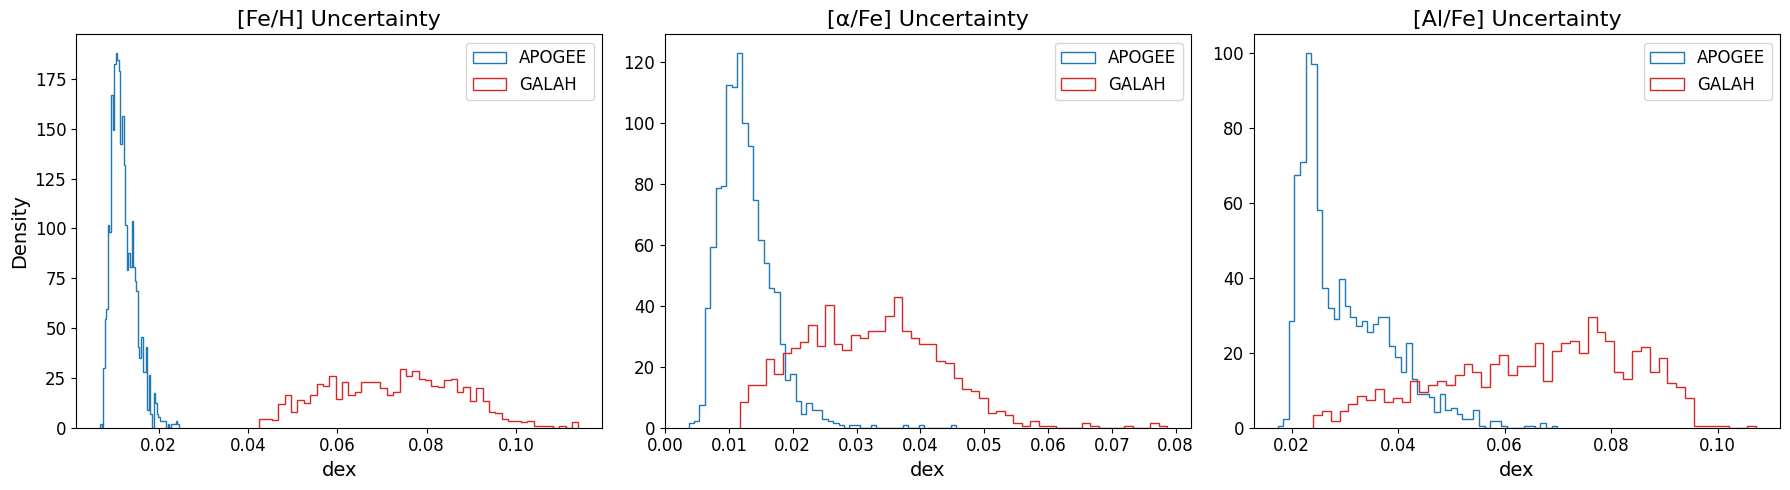

In [32]:
label_fontsize = 14
title_fontsize = 16
tick_fontsize = 12
legend_fontsize = 12

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# [Fe/H] uncertainty 
axs[0].hist(apogee_fe_h_error, bins=50, density=True, alpha=1, label='APOGEE',
            color='tab:blue', histtype='step')
axs[0].hist(galah_fe_h_error, bins=50, density=True, alpha=1, label='GALAH',
            color='tab:red', histtype='step')
axs[0].set_title("[Fe/H] Uncertainty", fontsize=title_fontsize)
axs[0].set_xlabel("dex", fontsize=label_fontsize)
axs[0].set_ylabel("Density", fontsize=label_fontsize)
axs[0].legend(fontsize=legend_fontsize)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)

# [alpha/Fe] uncertainty 
axs[1].hist(apogee_alpha_m_error, bins=50, density=True, alpha=1, label='APOGEE',
            color='tab:blue', histtype='step')
axs[1].hist(galah_alpha_m_error, bins=50, density=True, alpha=1, label='GALAH',
            color='tab:red', histtype='step')
axs[1].set_title("[α/Fe] Uncertainty", fontsize=title_fontsize)
axs[1].set_xlabel("dex", fontsize=label_fontsize)
axs[1].legend(fontsize=legend_fontsize)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)

# [Al/Fe] uncertainty
axs[2].hist(apogee_al_fe_error, bins=50, density=True, alpha=1, label='APOGEE',
            color='tab:blue', histtype='step')
axs[2].hist(galah_al_fe_error, bins=50, density=True, alpha=1, label='GALAH',
            color='tab:red', histtype='step')
axs[2].set_title("[Al/Fe] Uncertainty", fontsize=title_fontsize)
axs[2].set_xlabel("dex", fontsize=label_fontsize)
axs[2].legend(fontsize=legend_fontsize)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()

## **Visualising the Eccentricity Cut**
- Within our original data cuts, we have applied an eccentricity cut of >0.85, removing most stars on near-circular, rotationally-supported orbits
- These typically correspond to those with greater angular momentum and higher azimuthal velocity $V_\phi$.

## Practically:
- Stars with low eccentricity ($e \sim 0$) follow near-circular orbits — like those in the disc — and typically have:
  - $V_\phi \sim 220\ \mathrm{km/s}$
- By imposing $e > 0.85$, we have selected:
  - Stars on radial orbits with low angular momentum, where $V_\phi$ is often:
    - Near zero (randomized motion)

In [33]:
# Load the APOGEE dataset that has just been created
apogee_data_highdim_clustering = Table.read('data/filtered/Apogee/Apogee_data_filtered_1612.fits', format='fits')

# Load full original APOGEE catalog
all_apogee = Table.read("data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits")

In [34]:
# Get the FE/H and V_PHI values from the APOGEE dataset that will be used for the analysis

# The required columns from the APOGEE catalog that will allow the calculation of the Azimuthal velocity
# [ID for matching, RA, DEC, proper motion in RA, proper motion in DEC, photogeometric distance, and radial velocity]
# Apogee's radial velocity is used as it is more accurate than Gaia's
needed_cols = ['APOGEE_ID', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMDEC', 'GAIAEDR3_R_MED_PHOTOGEO', 'VHELIO_AVG']
all_apogee = all_apogee[needed_cols]

# Rename columns to enable matched joining (as cluster data has lowercase 'apogee_id')
all_apogee.rename_column('APOGEE_ID', 'apogee_id')

# Join the tables together based on the 'APOGEE_ID' column
matched = join(apogee_data_highdim_clustering, all_apogee, keys='apogee_id', join_type='inner')
# Avoid duplicate columns by only taking the first occurrence of each column
unique_ids, first_indices = np.unique(matched['apogee_id'], return_index=True)
matched_unique = matched[first_indices]
matched = matched_unique

# Define Galactocentric frame with custom solar motion
v_sun = CartesianDifferential([11.1, 245., 7.25] * u.km/u.s)
gc_frame = Galactocentric(galcen_distance=8.1 * u.kpc, z_sun=25. * u.pc, galcen_v_sun=v_sun)

# Construct SkyCoord with proper motion, photogeometric distance, and APOGEE radial velocity
coord = SkyCoord(ra=matched['RA'] * u.deg,
                 dec=matched['DEC'] * u.deg,
                 distance=matched['GAIAEDR3_R_MED_PHOTOGEO'] * u.pc,
                 pm_ra_cosdec=matched['GAIAEDR3_PMRA'] * u.mas/u.yr,
                 pm_dec=matched['GAIAEDR3_PMDEC'] * u.mas/u.yr,
                 radial_velocity=matched['VHELIO_AVG'] * u.km/u.s,
                 frame='icrs')

# Ensure that there was a match for all the stars in the original star data
print(f"Length of original star_data_edit: {len(apogee_data_highdim_clustering)}")
print(f"Length of matched table: {len(matched)}")

# Transform to Galactocentric and set cylindrical representation
galcen_coords = coord.transform_to(gc_frame)
galcen_coords.representation_type = 'cylindrical'

# Extract position and velocity in cylindrical form
cg_cyl = galcen_coords.represent_as(CylindricalRepresentation)
cg_cyl_vel = galcen_coords.represent_as(CylindricalRepresentation, CylindricalDifferential).differentials['s']

# Convert d_phi (rad/yr) to rad/s and rho (pc) to km
d_phi_rad_s = cg_cyl_vel.d_phi.to(u.rad / u.s)
rho_km = cg_cyl.rho.to(u.km)

# Compute v_phi (linear azimuthal velocity) with negative sign
v_phi_kms = -(d_phi_rad_s * rho_km)

# Clean and convert for use
vphi_vals = v_phi_kms.value
mask = ~np.isnan(vphi_vals)
vphi_vals_clean = vphi_vals[mask]

# Filter values
feh_vals_subset = apogee_data_highdim_clustering['fe_h'][mask]
vphi_vals_filtered_subset = vphi_vals_clean


Length of original star_data_edit: 1612
Length of matched table: 1612


In [35]:
# Get the FE/H vs V_PHI values from the full APOGEE dataset

# Load full original APOGEE catalog
all_apogee = Table.read("data/raw/Total_Apogee/ApogeeDR17_allStarLite.fits")

# The required columns from the APOGEE catalog that will allow the calculation of the Azimuthal velocity
# [ID for matching, RA, DEC, proper motion in RA, proper motion in DEC, photogeometric distance, and radial velocity]
# Apogee's radial velocity is used as it is more accurate than Gaia's
needed_cols = ['APOGEE_ID', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMDEC', 'GAIAEDR3_R_MED_PHOTOGEO', 'VHELIO_AVG', 'FE_H']
all_apogee = all_apogee[needed_cols]


# Define Galactocentric frame with custom solar motion
v_sun = CartesianDifferential([11.1, 245., 7.25] * u.km/u.s)
gc_frame = Galactocentric(galcen_distance=8.1 * u.kpc, z_sun=25. * u.pc, galcen_v_sun=v_sun)

# Construct SkyCoord with proper motion, photogeometric distance, and APOGEE radial velocity
coord = SkyCoord(ra=all_apogee['RA'] * u.deg,
                 dec=all_apogee['DEC'] * u.deg,
                 distance=all_apogee['GAIAEDR3_R_MED_PHOTOGEO'] * u.pc,
                 pm_ra_cosdec=all_apogee['GAIAEDR3_PMRA'] * u.mas/u.yr,
                 pm_dec=all_apogee['GAIAEDR3_PMDEC'] * u.mas/u.yr,
                 radial_velocity=all_apogee['VHELIO_AVG'] * u.km/u.s,
                 frame='icrs')

# Transform to Galactocentric and set cylindrical representation
galcen_coords = coord.transform_to(gc_frame)
galcen_coords.representation_type = 'cylindrical'

# Extract position and velocity in cylindrical form
cg_cyl = galcen_coords.represent_as(CylindricalRepresentation)
cg_cyl_vel = galcen_coords.represent_as(CylindricalRepresentation, CylindricalDifferential).differentials['s']

# Convert d_phi (rad/yr) to rad/s and rho (pc) to km
d_phi_rad_s = cg_cyl_vel.d_phi.to(u.rad / u.s)
rho_km = cg_cyl.rho.to(u.km)

# Compute v_phi (linear azimuthal velocity) with negative sign
v_phi_kms_all = -(d_phi_rad_s * rho_km)

# Clean and convert for use
vphi_vals_all = v_phi_kms_all.value
mask = ~np.isnan(vphi_vals_all) & ~np.isnan(all_apogee['FE_H'])
vphi_vals_clean = vphi_vals_all[mask]
# 
feh_vals = all_apogee['FE_H'][mask]
vphi_vals_filtered = vphi_vals_clean

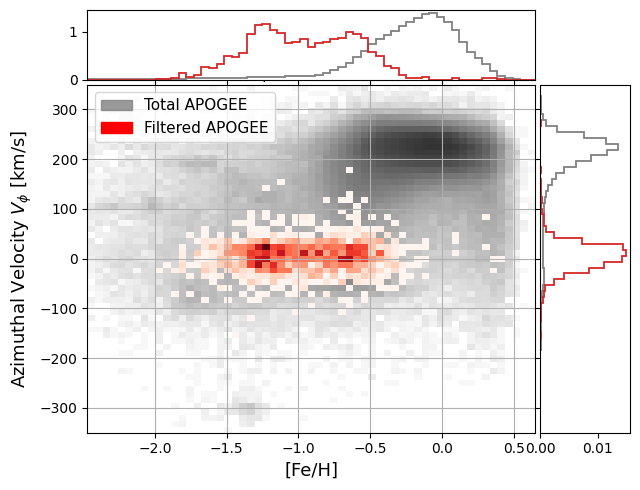

In [36]:
#  Define binning manually so both hist2d plots align
x_bins = np.linspace(np.nanmin(feh_vals), 0.65, 60)
y_bins = np.linspace(-350, 350, 60)

# Create figure and axes
fig, ax_main = plt.subplots(figsize=(6.5, 5))
divider = make_axes_locatable(ax_main)
ax_histx = divider.append_axes("top", size="20%", pad=0.05, sharex=ax_main)
ax_histy = divider.append_axes("right", size="20%", pad=0.05, sharey=ax_main)

# 2D histogram background (full sample)
h1 = ax_main.hist2d(feh_vals, vphi_vals_filtered, bins=[x_bins, y_bins], cmap='Greys', norm=LogNorm(), cmin=1, alpha=0.8)
# 2D histogram overlay (subset)
h2 = ax_main.hist2d(feh_vals_subset, vphi_vals_filtered_subset, bins=[x_bins, y_bins], cmap='Reds', cmin=1, alpha=1)

# Set x and y limits explicitly
ax_main.set_xlim(np.nanmin(feh_vals), 0.65)
ax_main.set_ylim(-350, 350)

# Labels and title
ax_main.set_xlabel(r"[Fe/H]", fontsize=13)
ax_main.set_ylabel(r"Azimuthal Velocity $V_\phi$ [km/s]", fontsize=13)
ax_main.set_title(r"[Fe/H] vs. $V_\phi$ with Subset Overlay", fontsize=14)

# Marginal histograms (Top X, normalized)
ax_histx.hist(feh_vals, bins=x_bins, density=True, color='grey', histtype='step', linewidth=1.3, label='Full Sample')
ax_histx.hist(feh_vals_subset, bins=x_bins, density=True, color='tab:red', histtype='step', linewidth=1.3, label='Subset')

# Marginal histograms (Right Y, normalized)
ax_histy.hist(vphi_vals_filtered, bins=y_bins, density=True, orientation='horizontal', color='grey', histtype='step', linewidth=1.3)
ax_histy.hist(vphi_vals_filtered_subset, bins=y_bins, density=True, orientation='horizontal', color='tab:red', histtype='step', linewidth=1.3)

# Hide tick labels for histograms
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

# Tick formatting
ax_histx.tick_params(axis='y', labelsize=10)
ax_histy.tick_params(axis='x', labelsize=10)

# Add legend
legend_titles = [
    Patch(facecolor='grey', edgecolor='grey', label='Total APOGEE', alpha=0.8),
    Patch(facecolor='red', edgecolor='red', label='Filtered APOGEE', alpha=1.0)]

# Add legend to the main (central) plot
ax_main.legend(handles=legend_titles, loc='upper left', fontsize=11, frameon=True)

# Grid and layout
ax_main.grid(True)
fig.tight_layout()
plt.show()